# FGSM by torchattacks

## Preprocessing

### Load pretraiend model resnet56 from torch.hub

In [17]:
import torch
model = torch.hub.load("./pytorch-cifar-models", "cifar10_resnet56", pretrained=True,source='local')

### Load dataset from CIFAR-10

In [18]:
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import torchattacks

use_cuda = True
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]
transform = transforms.Compose(
    [transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
     transforms.Normalize(norm_mean, norm_std),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

org_img = []
org_labels = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        org_img.append(images)
        org_labels.append(labels)


### Test accuracy of the model

In [19]:
# Small test
st = 100
# Midium test
mt = 400
# Large test
lt = 1000
# Full test
ft = 2500

In [20]:
def test_acc_new(model, testloader, test_images, n_image = 100, save_test_images = False):
    correct = 0
    total = 0
    p_labels = []
    saved_img = []
    i = 0
    for data in testloader:
        images, labels = data
        if total < n_image:
            outputs = model(test_images[i])
            _, predicted = torch.max(outputs.data, 1)
            for j in labels:
                if save_test_images and total % 4 == 0:
                    saved_img.append(test_images[total])
#                 print(predicted, j)

                p_labels.append(predicted)
                if predicted[total%4] == j:
                    correct += 1
                total += 1
            if total % 40 == 0:
                print("Iterations:{} / {} \n Test Accuracy = {} / {} = {}".format(total, n_image,  correct, total, str(correct / total)[:4]))
            i += 1
        else:
            break
    test_accuracy = (100.0 * correct / total)
    print('Accuracy of the network on the', total, "images is: ", test_accuracy, '%')
    print("Saving test images = ", save_test_images)
    if save_test_images == True:
        return test_accuracy, p_labels, saved_img
    else:
        return test_accuracy, p_labels

In [21]:
test_accuracy, resnet56_labels, orig = test_acc_new(model, testloader, org_img, mt, True)

Iterations:40 / 400 
 Test Accuracy = 33 / 40 = 0.82
Iterations:80 / 400 
 Test Accuracy = 62 / 80 = 0.77
Iterations:120 / 400 
 Test Accuracy = 93 / 120 = 0.77
Iterations:160 / 400 
 Test Accuracy = 122 / 160 = 0.76
Iterations:200 / 400 
 Test Accuracy = 146 / 200 = 0.73
Iterations:240 / 400 
 Test Accuracy = 174 / 240 = 0.72
Iterations:280 / 400 
 Test Accuracy = 206 / 280 = 0.73
Iterations:320 / 400 
 Test Accuracy = 233 / 320 = 0.72
Iterations:360 / 400 
 Test Accuracy = 265 / 360 = 0.73
Iterations:400 / 400 
 Test Accuracy = 297 / 400 = 0.74
Accuracy of the network on the 400 images is:  74.25 %
Saving test images =  True


## FGSM attack

### Tool functions

In [22]:
# def unnormalize(img, mean = np.array(norm_mean), std = np.array(norm_std)):
#     '''
#     unnormalize the image that has been normalized with mean and std
#     '''
#     inverse_mean = - mean/std
#     inverse_std = 1/std
#     img = transforms.Normalize(mean=-mean/std, std=1/std)(img)
#     return img

# def imshow(img):
#     img = img / 2 + 0.5     # unnormalize
#     npimg = img.numpy()
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))

# def ax_imshow(ax, img, label):
#     img = unnormalize(img)     # unnormalize
#     img = np.clip(img, 0., 1.)
#     ax.set_xticks([])
#     ax.set_yticks([])
#     img = np.transpose(img, (1,2,0))
#     ax.imshow(img)
#     ax.set_title(classes[label])

### Implement torchattacks.FGSM

In [23]:
test_loader_1=torch.utils.data.DataLoader(testset,batch_size=1,shuffle=True)
epsilons = []
init_eps = 0
accuracies=[]
step = 0.1
n_step = 5

for i in range(n_step):
    epsilons.append(init_eps + i*step)

# Run test for each epsilon


In [24]:
print(epsilons)

[0.0, 0.1, 0.2, 0.30000000000000004, 0.4]


In [25]:
for eps in epsilons:
    visual_examples = 5
    fgsm_examples = []
    fgsm_img = []
    attack = torchattacks.FGSM(model, eps)
    count = 0
    for i in range(500):
        fgsm_img.append(attack(org_img[i], org_labels[i]))
    fgsm_test_accuracy, fgsm_labels , a_images= test_acc_new(model, testloader, fgsm_img, mt, True)
    accuracies.append(fgsm_test_accuracy)
    fgsm_examples.append(a_images)

Iterations:40 / 400 
 Test Accuracy = 30 / 40 = 0.75
Iterations:80 / 400 
 Test Accuracy = 47 / 80 = 0.58
Iterations:120 / 400 
 Test Accuracy = 69 / 120 = 0.57
Iterations:160 / 400 
 Test Accuracy = 93 / 160 = 0.58
Iterations:200 / 400 
 Test Accuracy = 115 / 200 = 0.57
Iterations:240 / 400 
 Test Accuracy = 140 / 240 = 0.58
Iterations:280 / 400 
 Test Accuracy = 161 / 280 = 0.57
Iterations:320 / 400 
 Test Accuracy = 183 / 320 = 0.57
Iterations:360 / 400 
 Test Accuracy = 207 / 360 = 0.57
Iterations:400 / 400 
 Test Accuracy = 231 / 400 = 0.57
Accuracy of the network on the 400 images is:  57.75 %
Saving test images =  True
Iterations:40 / 400 
 Test Accuracy = 24 / 40 = 0.6
Iterations:80 / 400 
 Test Accuracy = 38 / 80 = 0.47
Iterations:120 / 400 
 Test Accuracy = 58 / 120 = 0.48
Iterations:160 / 400 
 Test Accuracy = 81 / 160 = 0.50
Iterations:200 / 400 
 Test Accuracy = 99 / 200 = 0.49
Iterations:240 / 400 
 Test Accuracy = 113 / 240 = 0.47
Iterations:280 / 400 
 Test Accuracy = 1

In [26]:
print(accuracies)

[57.75, 47.0, 43.0, 40.75, 39.0]


In [ ]:
plt.figure(figsize=(5,5))
plt.plot([0] + epsilons, [test_accuracy] + accuracies, "*-")
plt.yticks(np.arange(0.0, test_accuracy, step=10))
plt.xticks(np.arange(0.0, max(epsilons), step=max(epsilons)/5))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

In [31]:
def unnormalize(img, mean = np.array(norm_mean), std = np.array(norm_std)):
    '''
    unnormalize the image that has been normalized with mean and std
    '''
    inverse_mean = - mean/std
    inverse_std = 1/std
    img = transforms.Normalize(mean=-mean/std, std=1/std)(img)
    return img

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def ax_imshow(ax, img, label):
    img = unnormalize(img)     # unnormalize
    img = np.clip(img, 0., 1.)
    ax.set_xticks([])
    ax.set_yticks([])
    img = np.transpose(img, (1,2,0))
    ax.imshow(img)
    ax.set_title(classes[label])

In [34]:
# #print(orig[0].shape, adv_ex.shape)
# print(len(resnet56_labels))
# print(len(fgsm_labels))
# #print(resnet56_labels.shape)
# print(labels.shape)
# #print('%5s' % classes[resnet56_labels[i][j]])
# print(len(nnoise_labels), noised_img.shape)
# print(resnet56_labels[0])
# print(fgsm_labels[0][0])

GroundTruth:    cat  ship  ship plane


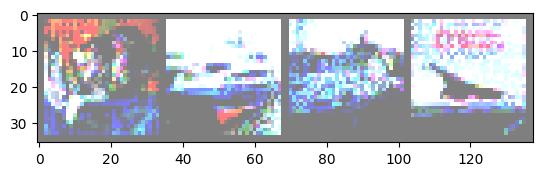

In [35]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(a_images[0]))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))